# Molekulák hasonlóság-alapú keresése

Ezen az órán egyfajta "molekuláris Google"-t fogunk építeni. Megvizsgáljuk, hogy hogyan lehet bonyolult molekulákat a számítógép számára érthetően reprezentálni, illetve a hasonlóságukat értelmezni. Ezeket a technikákat gyakran használják a gyógyszerkutatás kezdeti fázisában, amikor nagy mennyiségű vegyület közül kell kiválasztani azt "aktívakat" (pl. amelyek képesek egy adott betegség kialakulásában szerepet játszó célfehérjéhez hozzákötődni). Ennek egyik módja az ún. *ligand-alapú virtuális szűrés*.

Az alapötlet egyszerű: vegyünk egy nagy molekula-adatbázist (ma már sok ilyen létezik, pl. ChEMBL, PubChem), majd keressünk benne olyan molekulákat, amelyek szerkezetüket tekintve hasonlítanak az ismert aktívakhoz. A szerves kémiában ismert *hasonló tulajdonságok elve* (SPP) alapján ezektől joggal várhatjuk, hogy a szerkezeti hasonlóság hasonló kémiai tulajdonságokban fog megnyilvánulni. Az így előszűrt adatbázist aztán kísérleti úton lehet tovább szűkíteni. A virtuális szűrésről további információ: https://en.wikipedia.org/wiki/Virtual_screening

In [2]:
%pylab inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdFMCS
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

from urllib.request import urlopen

Populating the interactive namespace from numpy and matplotlib


## SMILES-kódok

A molekulák reprezentációjának egyik módja a SMILES-kód, ami egy tömör összefoglalása a szerkezeti képletnek. Ez ember és gép számára is többé-kevésbé érthető, néhány példa:

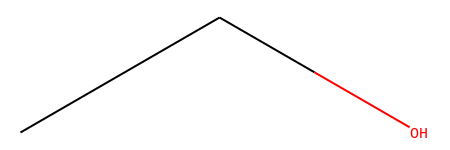

In [3]:
Chem.MolFromSmiles("CCO") # etilalkohol (a szenek és hidrogének nincsenek külön jelölve)

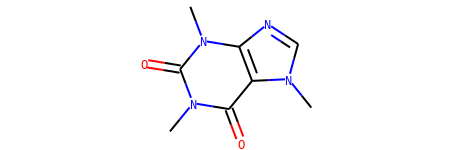

In [4]:
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # koffein

## Molekulák letöltése

Letöltünk egy molekula-adatbázist, ami SMILES-kódokat tartalmaz.

In [5]:
url = "https://www.mit.bme.hu/system/files/oktatas/targyak/10027/mols.txt"
txt = urlopen(url).read().decode('utf8').split('\n')[:-1]
print(txt[0])
print(txt[1])

granisetron	CN1N=C(C(=O)NC2CC3CCCC(C2)N3C)C2=CC=CC=C12
dienestrol	CC=C(C(=CC)C1=CC=C(O)C=C1)C1=CC=C(O)C=C1


## Molekuláris ujjlenyomatok

A SMILES-kódokból közvetlenül nehéz hasonlóságokat számolni, ezért ezeket átfordítjuk egy tisztán matematikai reprezentációra. Erre jópár módszer létezik. Gyakori, hogy a sok-sok lehetséges szerkezeti jegyhez (pl. aromás gyűrűk, elágazó szénláncok, heteroatomos részstruktúrák stb.) bináris változókat rendelünk, majd megvizsgáljuk, hogy megtalálhatók-e az adott molekulában vagy sem. A kapott az igen/nem válaszokat egymás mellé téve keletkezik a molekuláris reprezentáció, amelyet ujjlenyomatnak (fingerprint) nevezünk. Most az adatbázis minden molekulájához kiszámítjuk az ún. ECFP (vagy Morgan) ujjlenyomatot a SMILES-kódból:

In [ ]:
mols,names,fps,pos = [],[],[],{}
for t in range(len(txt)):
  name,smiles = txt[t].split('\t')
  
  mol   = Chem.MolFromSmiles(smiles)
  fp    = AllChem.GetMorganFingerprintAsBitVect(mol,2,1024)
  arr   = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp,arr)
  
  mols  += [mol]
  names += [name]
  fps   += [arr]
  pos[name] = t

fps = array(fps)

In [7]:
print(names[0],fps[0])
print(names[1],fps[1])

granisetron [0. 1. 0. ... 0. 0. 0.]
dienestrol [0. 0. 0. ... 0. 0. 0.]


## Hasonlóságok kiszámítása

Most már minden molekulához van egy-egy bináris vektorunk, amelyeket könnyen össze tudunk hasonlítani. Hasonlóságként használhatjuk például az ezek által bezárt szög koszinuszát:

$$\cos(\alpha) = \frac{x \cdot y}{\left|x \right| \left|y \right|}  ,$$

ami tényleg akkor maximális, ha a két vektor megegyezik. Másik lehetőség az ún. Tanimoto-hasonlóság:

$$T(x,y) = \frac{x \cdot y}{\left|x \right|^2 + \left|y \right|^2 - x \cdot y}  .$$

Számítsuk ki minden párra a hasonlóságot, és tegyük el az eredményeket egy mátrixba.

In [ ]:
N  = len(fps)
x2 = fps @ fps.T
xd = np.diag(x2)
K  = x2 / ( np.outer(xd,np.ones(N)) + np.outer(np.ones(N),xd) - x2) # Tanimoto hasonlóság

## Hasonlósági keresés

Most már könnyen megkereshetjük az adott molekulához leginkább hasonlókat, csak a mátrix megfelelő sorát kell rendeznünk. A név után zárójelben a hasonlóság mértéke látható. Nem véletlen, hogy a kapott molekulák nevei hasonlítanak egymáshoz! Az amoxicillin-ből kiindulva például további penicillin-származékokat, majd közeli rokonokat, cefalosporinokat kapunk. Ezek mind ún. béta-laktám antibiotikumok, amelyek a bakteriális sejtfal-szintézist gátolják.

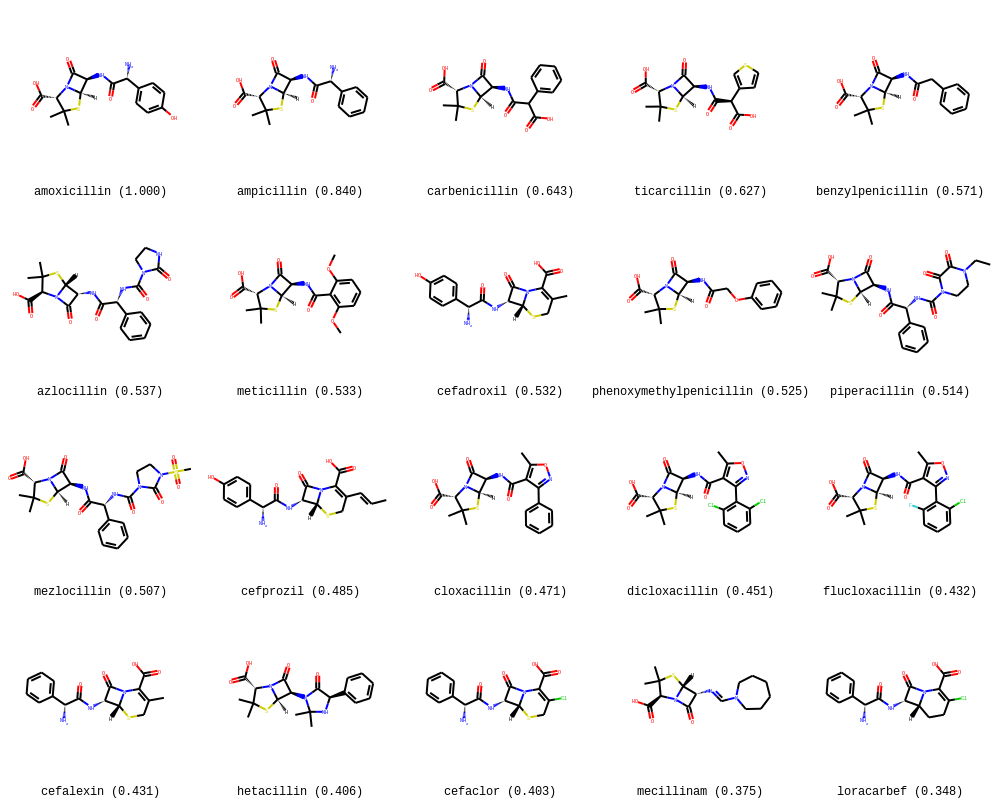

In [9]:
mol  = "amoxicillin"
srt  = np.argsort(-K[pos[mol]])[:20]
mgrp = [mols[s]  for s in srt]
mnm  = ["{} ({:.3f})".format(names[s],K[pos[mol],s]) for s in srt]
MolsToGridImage(mgrp, molsPerRow=5, legends = mnm, useSVG=False)

## Közös részstruktúrák keresése

Az előbbi példában béta-laktám antibiotikumok szerepeltek, ahol ez az elnevezés a bennük meglévő béta-laktám gyűrűre utal. Az RDKit-tel könnyen megkereshetjük a közös szerkezetet:

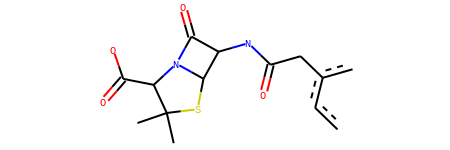

In [10]:
smarts = Chem.rdFMCS.FindMCS(mgrp[:4]).smartsString
mcs = Chem.MolFromSmarts(smarts)
mcs

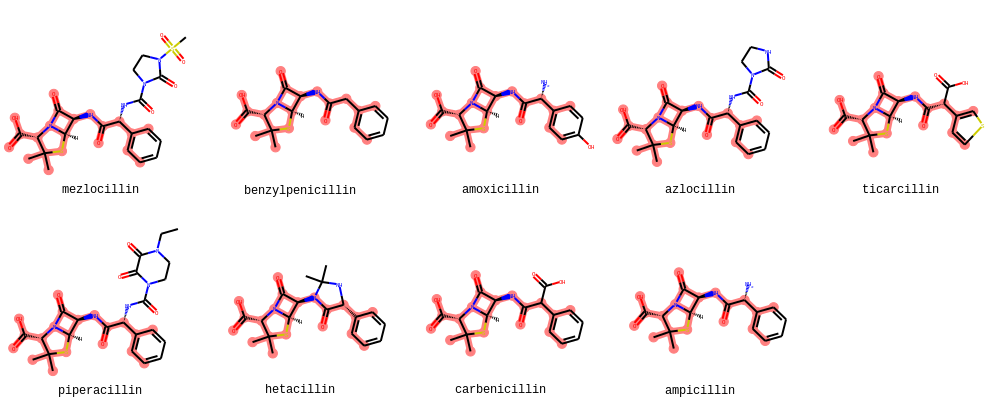

In [11]:
mgrp,mnm = [],[]
for i in range(N):
  if mols[i].HasSubstructMatch(mcs):
    mgrp += [mols[i]]
    mnm  += [names[i]]

AllChem.Compute2DCoords(mcs)
for m in mgrp:
    AllChem.GenerateDepictionMatching2DStructure(m,mcs)
MolsToGridImage(mgrp, molsPerRow=5, legends=mnm, useSVG=False, highlightAtomLists=[m.GetSubstructMatch(mcs) for m in mgrp])

## Molekulák csoportosítása, csoport-alapú szűrés

... leírás coming soon...

In [ ]:
from sklearn.cluster import SpectralClustering

cl = SpectralClustering(100,affinity="precomputed").fit_predict(K)

In [13]:
[names[i] for i in range(N) if cl[i] == cl[pos[mol]]]

['mezlocillin',
 'benzylpenicillin',
 'amoxicillin',
 'azlocillin',
 'meticillin',
 'pivmecillinam',
 'ticarcillin',
 'flucloxacillin',
 'piperacillin',
 'cloxacillin',
 'hetacillin',
 'carbenicillin',
 'ampicillin',
 'phenoxymethylpenicillin',
 'mecillinam',
 'dicloxacillin']

In [ ]:
from sklearn.svm import OneClassSVM

query = ["amoxicillin","piperacillin","ampicillin"]
qp    = [pos[q] for q in query]

svm = OneClassSVM(kernel="precomputed").fit(K[qp][:,qp])

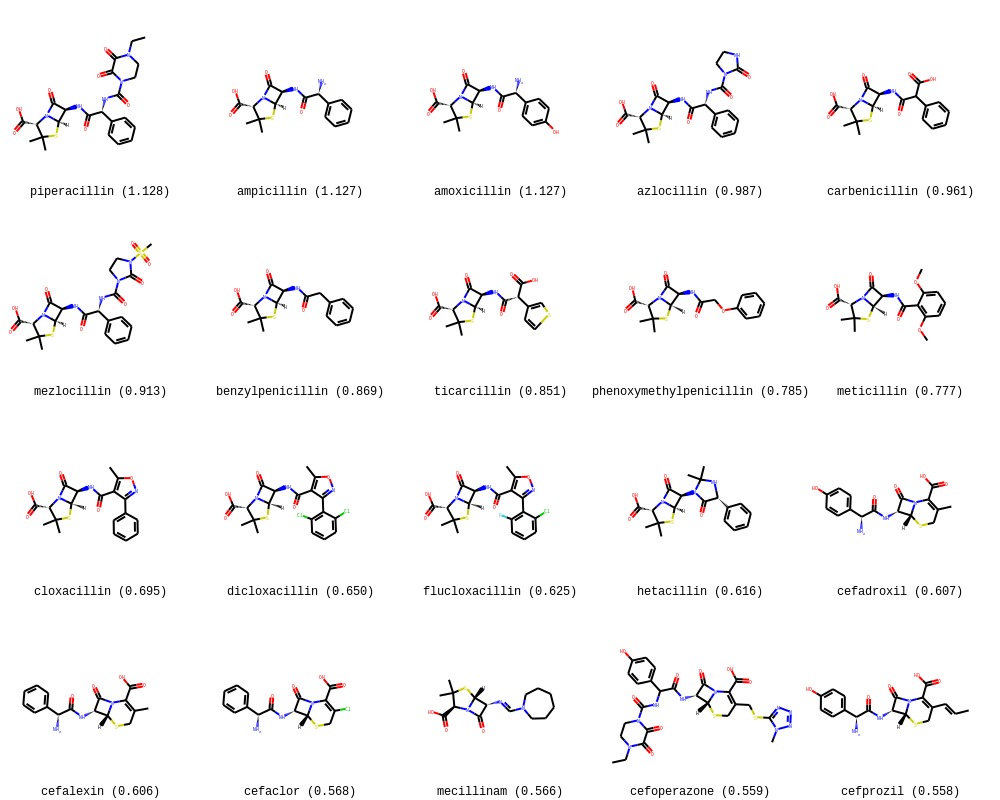

In [15]:
scores = (svm.decision_function(K[:,qp]) - svm.intercept_).flatten()
srt  = np.argsort(-scores)[:20]
mgrp = [mols[s]  for s in srt]
mnm  = ["{} ({:.3f})".format(names[s],scores[s]) for s in srt]
MolsToGridImage(mgrp, molsPerRow=5, legends = mnm, useSVG=False)